# Introduction to Probabilistic Graphical Models
## Practical Session 1: Forward-Backward Algorithm for Hidden Markov Model
**Student: VU Thi Hai Yen (haiyen96.hp@gmail.com)**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Log-sum-exp trick

In [3]:
#Question 0:
def logsumexp(v):
    v = np.array(v)
    a = np.max(v)
    u = v-a
    return np.log(np.sum(np.exp(u)))+a

v = [-1234, -1235]
print(logsumexp(v))

-1233.6867383124818


### Simulation of positions and obervations

In [4]:
# Simulation
N = 10
eps = 0.3
w = 0.9
steps = 100

In [5]:
def generate(N,eps,w,steps=100):
    X = []
    Y = []
    import random

    for step in range(steps):
        if step == 0:
            current_position = random.randint(0,N-1)
            X.append(current_position)
        else:
            last_position = X[step-1]
            if random.random() <= eps:
                current_position = last_position
            else:
                current_position = (last_position + 1) %N
            X.append(current_position)
        if random.random() <= w:
            predict = current_position
        else:
            predict = random.randint(0,N-1)
        Y.append(predict)
    return np.asarray(X), np.asarray(Y)

In [6]:
X_gen, Y_gen = generate(N,eps,w,steps)

In [7]:
X_gen

array([0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 1, 2, 2, 2, 3, 4, 5, 6,
       7, 8, 9, 0, 0, 1, 2, 2, 2, 3, 4, 5, 5, 5, 6, 7, 7, 8, 9, 0, 1, 2,
       2, 3, 3, 4, 4, 5, 5, 5, 6, 7, 8, 9, 0, 1, 1, 2, 3, 4, 5, 6, 6, 6,
       7, 8, 9, 0, 1, 2, 2, 3, 3, 3, 3, 3, 4, 5, 5, 6, 7, 8, 9, 9, 0, 1,
       1, 2, 2, 3, 4, 5, 5, 6, 7, 8, 9, 0])

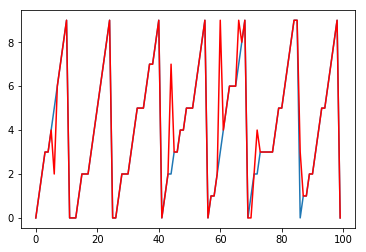

In [8]:
plt.plot(X_gen)
plt.plot(Y_gen,color='r')

### Forward-Backward Algorithm

In [9]:
# Matrix transitions and observations:
I = np.eye(N)
K = np.roll(I, N-1, axis=0) # Circular permutation
T = eps * I + (1-eps) * K
B = (1-w)/(N) * np.ones((N, N)) + (w) * np.eye(N)

In [10]:
def forward(steps, B, T,observations, initial=None):
    """
    Forward pass, compute alpha_k = (alpha_k(0),alpha_k(1),...,alpha_k(n-1))
    """
    n_states = B.shape[0]
    if not initial:
        initial = np.ones(n_states)*1./n_states
        
    alpha_matrix = []
    current_alpha = initial
    alpha_matrix.append(current_alpha)
    for k in range(steps):
        current_alpha = B[:,observations[k]]*np.matmul(T,current_alpha)
        #current_alpha = current_alpha / np.linalg.norm(current_alpha,ord=1)
        alpha_matrix.append(current_alpha)
        
    return np.asarray(alpha_matrix)

In [11]:
def backward(steps, B, T,observations, final=None):
    """
    Backward pass, compute beta_k = (beta_k(0),beta_k(1),...,beta_k(n-1))
    """
    n_states = B.shape[0]
    if not final:
        final = np.ones(n_states)
        
    beta_matrix = []
    current_beta = final
    beta_matrix.append(current_beta)
    for k in reversed(range(steps)):
        current_beta = np.matmul(T.T,(B[:,observations[k]]*current_beta))
        #current_beta = current_beta / np.linalg.norm(current_beta,ord=1)
        beta_matrix.append(current_beta)
        
    beta_matrix.reverse()
        
    return np.asarray(beta_matrix)

In [12]:
def foward_backward(steps, B, T,observations,initial=None, final=None):
    alpha_matrix = forward(steps, B, T,observations, initial)
    beta_matrix = backward(steps, B, T,observations, final)
    
    gamma_matrix = []
    
    for k in range(alpha_matrix.shape[0]):
        current_gamma = alpha_matrix[k]*beta_matrix[k]
        current_gamma = current_gamma / np.linalg.norm(current_gamma,ord=1)
        gamma_matrix.append(current_gamma)
    
    return np.asarray(gamma_matrix)

In [13]:
pred = foward_backward(steps, B, T, observations = Y_gen)

In [14]:
X_pred = np.argmax(pred,axis=1)

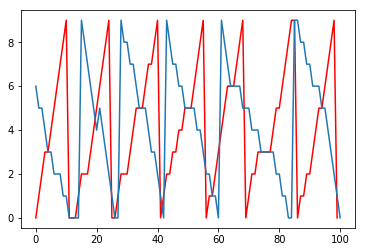

In [15]:
plt.plot(X_gen,color='r')
plt.plot(X_pred);


We see that the model not capable of generate well the true data, this is because the numerical error and we must use the log-sum-exp trick

In [16]:
def forward_log(steps, B, T,observations, initial=None):
    """
    Forward pass, compute log_alpha_k = (log_alpha_k(0),log_alpha_k(1),...,log_alpha_k(n-1))
    """
    n_states = B.shape[0]
    if not initial:
        initial = np.ones(n_states)*1./n_states
        
    log_alpha_matrix = []
    current_log_alpha = np.log(initial)
    log_alpha_matrix.append(current_log_alpha)
    for k in range(steps):
        new_log_alpha = []
        for j in range(N):
            new_log_alpha.append(logsumexp(current_log_alpha+np.log(T)[:,j]+np.log(B)[j,observations[k]]))
        current_log_alpha = new_log_alpha
        log_alpha_matrix.append(current_log_alpha)
        
    return np.asarray(log_alpha_matrix)

In [20]:
def backward_log(steps, B, T,observations, final=None):
    """
    Backward pass, compute beta_k = (beta_k(0),beta_k(1),...,beta_k(n-1))
    """
    n_states = B.shape[0]
    if not final:
        final = np.ones(n_states)
        
    log_beta_matrix = []
    current_log_beta = np.log(final)
    log_beta_matrix.append(current_log_beta)
    for k in reversed(range(steps)):
        new_log_beta = []
        for j in range(N):
            new_log_beta.append(logsumexp(current_log_beta+np.log(T)[j,:]+np.log(B)[:,observations[k]]))
        current_log_beta = new_log_beta
        log_beta_matrix.append(current_log_beta)
        
    log_beta_matrix.reverse()
        
    return np.asarray(log_beta_matrix)

In [21]:
def foward_backward_log(steps, B, T,observations,initial=None, final=None):
    log_alpha_matrix = forward_log(steps, B, T,observations, initial)
    log_beta_matrix = backward_log(steps, B, T,observations, final)
    
    log_gamma_matrix = []
    
    for k in range(log_alpha_matrix.shape[0]):
        current_log_gamma = log_alpha_matrix[k]+log_beta_matrix[k]
        log_gamma_matrix.append(current_log_gamma)
    
    return np.asarray(log_gamma_matrix)

In [22]:
pred_log = foward_backward_log(steps, B, T, observations = Y_gen)
X_pred_log = np.argmax(pred_log,axis=1)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


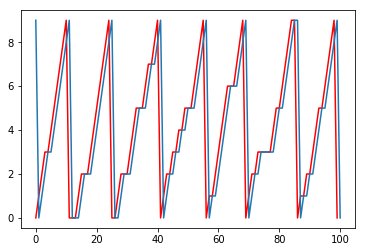

In [23]:
plt.plot(X_gen,color='r')
plt.plot(X_pred_log);

### The kidnap case

In [24]:
kidnap_rate=0.1

In [25]:
def generate_kidnap(N,eps,w,kidnap_rate,steps=100):
    X = []
    Y = []
    import random

    for step in range(steps):
        if step == 0:
            current_position = random.randint(0,N-1)
            X.append(current_position)
        else:
            if random.random() <= kidnap_rate:
                current_position = random.randint(0,N-1)
            else:
                last_position = X[step-1]

                if random.random() <= eps:
                    current_position = last_position
                else:
                    current_position = (last_position + 1) %N
            X.append(current_position)
        if random.random() <= w:
            predict = current_position
        else:
            predict = random.randint(0,N-1)
        Y.append(predict)
    return np.asarray(X), np.asarray(Y)

In [26]:
X_kidnap_gen, Y_kidnap_gen = generate_kidnap(N,eps,w,kidnap_rate,steps)

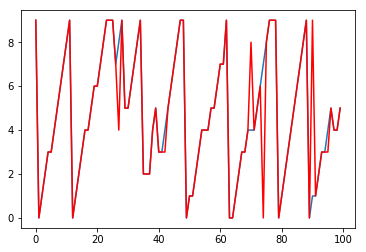

In [27]:
plt.plot(X_kidnap_gen)
plt.plot(Y_kidnap_gen,color='r') 

In [28]:
# Matrix transitions and observations:
I = np.eye(N)
K = np.roll(I, N-1, axis=0) # Circular permutation
T_kidnap = (1-kidnap_rate)*(eps * I + (1-eps) * K) + (kidnap_rate/N)* np.ones((N, N))
B_kidnap = (1-w)/(N) * np.ones((N, N)) + (w) * np.eye(N)

In [29]:
pred_kidnap = foward_backward(steps, B_kidnap, T_kidnap, observations = Y_kidnap_gen)

In [30]:
X_pred_kidnap = np.argmax(pred_kidnap,axis=1)

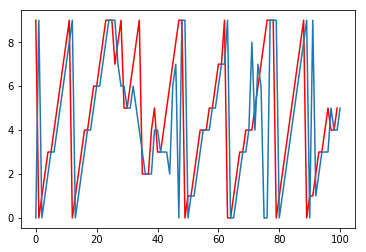

In [31]:
plt.plot(X_kidnap_gen,color='r')
plt.plot(X_pred_kidnap[0:]); #1-incremental to the right, if true take X_pred_kidnap[1:]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


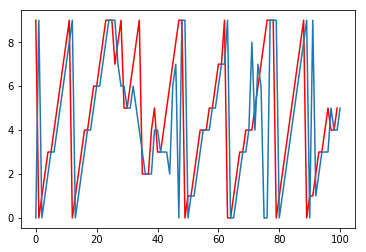

In [32]:
pred_log_kidnap = foward_backward_log(steps, B, T, observations = Y_kidnap_gen)
X_kidnap_pred_log = np.argmax(pred_log_kidnap,axis=1)
plt.plot(X_kidnap_gen,color='r')
plt.plot(X_pred_kidnap[0:]); #1-incremental to the right, if true take X_pred_kidnap[1:]